<a href="https://colab.research.google.com/github/MadhurimaPaul-87/Machine_Learning/blob/main/Research_Accurate.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Importing Libraries**

In [1]:
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline



In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [3]:
!ls gdrive/MyDrive/Covid_kaggle/dataset

covid  normal


In [4]:
DATASET_DIR='gdrive/MyDrive/Covid_kaggle/dataset'

**Looking at the input images**

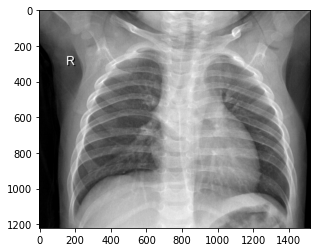

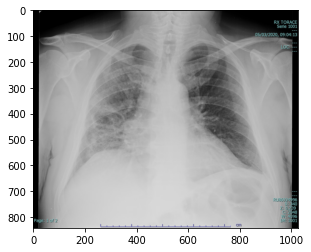

In [6]:
normal_images = [mpimg.imread(img_path) for img_path in glob.glob(DATASET_DIR+'/normal/*')]
covid_images = [mpimg.imread(img_path) for img_path in glob.glob(DATASET_DIR+'/covid/*')]

plt.imshow(normal_images[0], cmap='gray')
plt.figure()
plt.imshow(covid_images[0], cmap='gray')

**Image Augmentation using ImageDataGenerator**

In [9]:
from keras_preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale=1/255, 
                                   horizontal_flip=True,
                                   zoom_range=0.2,
                                   height_shift_range=0.2,
                                   width_shift_range=0.2,
                                   fill_mode='nearest',
                                   validation_split=0.25)


train_generator = train_datagen.flow_from_directory(DATASET_DIR,
                                                    target_size=(150,150),
                                                    class_mode='binary',
                                                    batch_size=3,
                                                    subset='training')
validation_generator = train_datagen.flow_from_directory(DATASET_DIR,
                                                       target_size=(150,150),
                                                       batch_size=3,
                                                       class_mode='binary',
                                                       subset='validation',
                                                       shuffle=True)

Found 74 images belonging to 2 classes.
Found 24 images belonging to 2 classes.


**Importing Local weights**

In [10]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.applications.inception_v3 import InceptionV3

!wget --no-check-certificate \
    https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5 \
    -O /tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5

--2021-05-08 19:20:19--  https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5
Resolving storage.googleapis.com (storage.googleapis.com)... 108.177.127.128, 172.217.218.128, 74.125.128.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|108.177.127.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 87910968 (84M) [application/x-hdf]
Saving to: ‘/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5’

/tmp/inception_v3_w 100%[===================>]  83.84M  39.4MB/s    in 2.1s    

2021-05-08 19:20:22 (39.4 MB/s) - ‘/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5’ saved [87910968/87910968]



**Creating a pretrained model(Inception)**

In [11]:
local_weights_file = '/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5'

pre_trained_model = InceptionV3(include_top=False, weights=None, input_shape=(150,150,3))
pre_trained_model.load_weights(local_weights_file)

for layer in pre_trained_model.layers:
    layer.trainable=False

last_layer = pre_trained_model.get_layer('mixed7')
last_output = last_layer.output

**Appending to the pretrained model**

In [12]:
from tensorflow.keras.optimizers import RMSprop
from tensorflow import keras


x = keras.layers.Flatten()(last_output)

x = keras.layers.Dense(512, activation='relu')(x)
x = keras.layers.Dropout(0.2)(x)
x = keras.layers.Dense(1, activation='sigmoid')(x)

model = keras.Model(inputs=pre_trained_model.input, outputs=x)

**Model Compilation**

In [13]:
model.compile(loss='binary_crossentropy',
              optimizer=RMSprop(lr=0.0001),
              metrics=['accuracy'])

**Training**

In [14]:
history = model.fit(
            train_generator,
            validation_data = validation_generator,
            epochs = 5,
            verbose = 2)

Epoch 1/5
25/25 - 14s - loss: 0.2909 - accuracy: 0.8784 - val_loss: 0.1786 - val_accuracy: 0.8750
Epoch 2/5
25/25 - 9s - loss: 0.1192 - accuracy: 0.9730 - val_loss: 0.0394 - val_accuracy: 1.0000
Epoch 3/5
25/25 - 9s - loss: 0.0365 - accuracy: 0.9865 - val_loss: 0.1347 - val_accuracy: 0.9583
Epoch 4/5
25/25 - 9s - loss: 0.0492 - accuracy: 0.9865 - val_loss: 0.0019 - val_accuracy: 1.0000
Epoch 5/5
25/25 - 9s - loss: 0.0021 - accuracy: 1.0000 - val_loss: 0.0807 - val_accuracy: 0.9583


**Plotting the loss and accuracy**

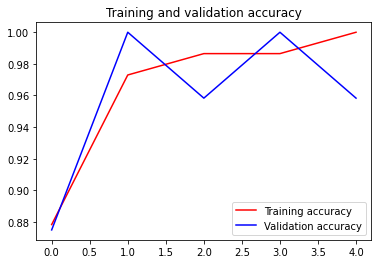

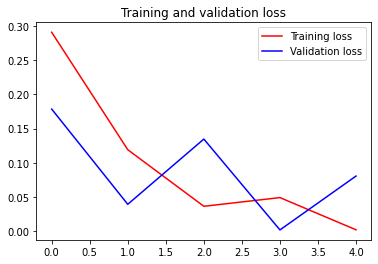

In [15]:
import matplotlib.pyplot as plt
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)

plt.figure()

plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend(loc=0)

plt.show()

**100% Accuracy**

In [17]:
print("training_accuracy", history.history['accuracy'][-1])
print("validation_accuracy", history.history['val_accuracy'][-1])

training_accuracy 1.0
validation_accuracy 0.9583333134651184


**Comparing the labels and predictions**

In [16]:
import numpy as np
pred = model.predict(validation_generator)
predicted_class_indices = np.argmax(pred,axis=1)
labels = dict((value,key) for key,value in validation_generator.class_indices.items())
predictions = [labels[key] for key in predicted_class_indices]
print(predicted_class_indices)
print (labels)
print (predictions)

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
{0: 'covid', 1: 'normal'}
['covid', 'covid', 'covid', 'covid', 'covid', 'covid', 'covid', 'covid', 'covid', 'covid', 'covid', 'covid', 'covid', 'covid', 'covid', 'covid', 'covid', 'covid', 'covid', 'covid', 'covid', 'covid', 'covid', 'covid']
